In [1]:
# db connection

import pymysql
from sqlalchemy import create_engine
import keyring
import platform
import numpy as np

user = 'root'
pw = keyring.get_password('macmini_db', user)
host = '192.168.219.106' if platform.system() == 'Windows' else '127.0.0.1'
port = 3306
db = 'stock'

# DATA COLUMNS

In [2]:
# base data
COLUMNS_STOCK_DATA = ['date', 'open', 'high', 'low', 'close', 'volume']
COLUMNS_TRAINING_DATA = ['open', 'high', 'low', 'close', 'volume', 'close_ma5', 'volume_ma5', 'close_ma5_ratio', 'volume_ma5_ratio',
       'open_close_ratio', 'open_prev_close_ratio', 'high_close_ratio',
       'low_close_ratio', 'close_prev_close_ratio', 'volume_prev_volume_ratio',
       'close_ma10', 'volume_ma10', 'close_ma10_ratio', 'volume_ma10_ratio',
       'close_ma20', 'volume_ma20', 'close_ma20_ratio', 'volume_ma20_ratio',
       'close_ma60', 'volume_ma60', 'close_ma60_ratio', 'volume_ma60_ratio',
       'close_ma120', 'volume_ma120', 'close_ma120_ratio',
       'volume_ma120_ratio', 'close_ma240', 'volume_ma240',
       'close_ma240_ratio', 'volume_ma240_ratio', 'upper_bb',
       'lower_bb', 'bb_pb', 'bb_width', 'macd',
       'macd_signal', 'macd_oscillator', 'rs', 'rsi']

## Device

In [3]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# UTILITIES

## Get stock data 

In [4]:
import pandas as pd
import pymysql
from sqlalchemy import create_engine


# get us stock price of a specific ticker
def get_stock_data(ticker, fro=None, to=None):

    # connect DB
    engine = create_engine(f'mysql+pymysql://{user}:{pw}@{host}:{port}/{db}')

    con = pymysql.connect(
        user=user,
        passwd=pw,
        host=host,
        db=db,
        charset='utf8'
    )
            
    mycursor = con.cursor()
    
    if fro is not None:
        if to is not None:               
            query = f""" 
                    SELECT * FROM price_global
                    WHERE ticker = '{ticker}'
                    AND date BETWEEN '{fro}' AND '{to}' 
                    """
        else:
            query = f""" 
                    SELECT * FROM price_global
                    WHERE ticker = '{ticker}'
                    AND date >= '{fro}'
                    """
    
    else:
        if to is not None:
            query = f""" 
                    SELECT * FROM price_global
                    WHERE ticker = '{ticker}'
                    AND date <= '{to}' 
                    """
        else:
            query = f""" 
                    SELECT * FROM price_global
                    WHERE ticker = '{ticker}'
                    """
            
    print(query)
    prices = pd.read_sql(query, con=engine)
    con.close()
    engine.dispose()
    return prices

### Sample code

In [5]:
stock_code = 'AAPL'
fro = '2018-01-01'
to = '2022-12-31'
df = get_stock_data(stock_code, fro=fro, to=to)

 
                    SELECT * FROM price_global
                    WHERE ticker = 'AAPL'
                    AND date BETWEEN '2018-01-01' AND '2022-12-31' 
                    


## Functions

### Sigmoid function

In [6]:
def sigmoid(x):
    x = max(min(x, 10), -10)
    return 1. / (1. + np.exp(-x))

## Preprocessing

In [7]:
def preprocess(data):
    
    # moving average
    windows = [5, 10, 20, 60, 120, 240]
    for window in windows:
        data[f'close_ma{window}'] = data['close'].rolling(window).mean()
        data[f'volume_ma{window}'] = data['volume'].rolling(window).mean()
        data[f'close_ma{window}_ratio'] = (data['close'] - data[f'close_ma{window}']) / data[f'close_ma{window}']
        data[f'volume_ma{window}_ratio'] = (data['volume'] - data[f'volume_ma{window}']) / data[f'volume_ma{window}']
        data['open_close_ratio'] = (data['open'].values - data['close'].values) / data['close'].values
        data['open_prev_close_ratio'] = np.zeros(len(data))
        data.loc[1:, 'open_prev_close_ratio'] = (data['open'][1:].values - data['close'][:-1].values) / data['close'][:-1].values
        data['high_close_ratio'] = (data['high'].values - data['close'].values) / data['close'].values
        data['low_close_ratio'] = (data['low'].values - data['close'].values) / data['close'].values
        data['close_prev_close_ratio'] = np.zeros(len(data))
        data.loc[1:, 'close_prev_close_ratio'] = (data['close'][1:].values - data['close'][:-1].values) / data['close'][:-1].values 
        data['volume_prev_volume_ratio'] = np.zeros(len(data))
        data.loc[1:, 'volume_prev_volume_ratio'] = (
            # if volume is 0, change it into non zero value exploring previous volume continuously
            (data['volume'][1:].values - data['volume'][:-1].values) / data['volume'][:-1].replace(to_replace=0, method='ffill').replace(to_replace=0, method='bfill').values
        )
    
    # Bollinger band
    data['middle_bb'] = data['close'].rolling(20).mean()
    data['upper_bb'] = data['middle_bb'] + 2 * data['close'].rolling(20).std()
    data['lower_bb'] = data['middle_bb'] - 2 * data['close'].rolling(20).std()
    data['bb_pb'] = (data['close'] - data['lower_bb']) / (data['upper_bb'] - data['lower_bb'])
    data['bb_width'] = (data['upper_bb'] - data['lower_bb']) / data['middle_bb']
    
    # MACD
    macd_short, macd_long, macd_signal = 12, 26, 9
    data['ema_short'] = data['close'].ewm(macd_short).mean()
    data['ema_long'] = data['close'].ewm(macd_long).mean()
    data['macd'] = data['ema_short'] - data['ema_long']
    data['macd_signal'] = data['macd'].ewm(macd_signal).mean()
    data['macd_oscillator'] = data['macd'] - data['macd_signal']
    
    # RSI
    data['close_change'] = data['close'].diff()
    # data['close_up'] = np.where(data['close_change'] >=0, df['close_change'], 0)
    data['close_up'] = data['close_change'].apply(lambda x: x if x >= 0 else 0)
    # data['close_down'] = np.where(data['close_change'] < 0, df['close_change'].abs(), 0)
    data['close_down'] = data['close_change'].apply(lambda x: -x if x < 0 else 0)
    data['rs'] = data['close_up'].ewm(alpha=1/14, min_periods=14).mean() / data['close_down'].ewm(alpha=1/14, min_periods=14).mean()
    data['rsi'] = 100 - (100 / (1 + data['rs']))
    
    
    return data

### Sample code

In [8]:
df_adj = preprocess(df)

## Load data

load_data() function is a combined function for getting data from databases and preprocessing it into training data.

In [9]:
def load_data(stock_code, fro, to):
    ''' 
    Arguments
    ----------
    - stock_code : unique stock code
    - fro : start date
    - to : end data
    
    Returns
    --------
    df_adj : entire prerprocessed data
    stock_data : data for plotting chart
    training_data : data for training a model
    '''
    
    df = get_stock_data(stock_code, fro, to)
    df_adj = preprocess(df).dropna().reset_index(drop=True)
    # df_adj.dropna(inplace=True).reset_index(drop=True)
    
    stock_data = df_adj[COLUMNS_STOCK_DATA]
    training_data = df_adj[COLUMNS_TRAINING_DATA]
    
    return df_adj, stock_data, training_data.values

### Sample code

In [10]:
df_adj, df_stock_data, df_training_data = load_data(stock_code, fro, to)

 
                    SELECT * FROM price_global
                    WHERE ticker = 'AAPL'
                    AND date BETWEEN '2018-01-01' AND '2022-12-31' 
                    


## Get epsilon value

In [11]:
def get_eps(step, eps_init=1.0, eps_final=0.05, eps_decrease_step=1000):
    # eps_init = self.eps_init
    # eps_final = self.eps_final
    if step >= eps_decrease_step:
        eps = eps_final
    else:
        m = (eps_final - eps_init) / eps_decrease_step
        eps = eps_init + m * step
    return eps

# ENVIRONMENT

In [12]:
# environment

import numpy as np
import pandas as pd

# environment

class Environment:
    ''' 
    Attribute
    ---------
    - stock_data : stock price data such as 'open', 'close', 'high', 'low', 'volume'
    - state : current state
    - idx : current postion of stock data
    
    
    Functions
    --------
    - reset() : initialize idx and state
    - observe() : move idx into next postion and get a new state
    - get_close_price() : get close price of current state
    - get_open_price() : get open price of current state
    - get_state() : get current state
    '''
    
    def __init__(self, stock_data=None):
        self.close_price_idx = 4    # index postion of close price
        self.open_price_idx = 1     # index position of open price
        self.stock_data = stock_data
        self.state = None
        self.idx = -1
        self.max_idx = len(stock_data)
        
    def reset(self):
        self.state = None
        self.idx = -1
        # self.idx = 0
        # self.state = self.stock_data.iloc[self.idx]
        
    def observe(self):
        # move to next day and get price data
        # if there is no more idx, return None
        if len(self.stock_data) > self.idx + 1:
            self.idx += 1
            self.state = self.stock_data.iloc[self.idx]
            return self.state
        return None
    
    def get_close_price(self):
        # return close price
        if self.state is not None:
            return self.state[self.close_price_idx]
        return None
    
    def get_next_close_price(self):
        # return tomorrow close price
        if self.idx < self.max_idx - 1:
            return self.stock_data.iloc[self.idx + 1, self.close_price_idx]
        else:
            return self.stock_data.iloc[self.idx, self.close_price_idx]
    
    def get_open_price(self):
        # return open price
        if self.state is not None:
            return self.state[self.open_price_idx]
        
    def get_next_open_price(self):
        # return tomorrow open price
        if self.idx < self.max_idx - 1:
            return self.stock_data.iloc[self.idx + 1, self.open_price_idx]
        else:
            return self.stock_data.iloc[self.idx, self.open_price_idx]
        
    
    def get_state(self):
        # return current state
        if self.state is not None:
            return self.state
        return None
        

### Sample code

In [13]:
env = Environment(df_stock_data)

In [14]:
env.reset()

In [15]:
env.get_state()

In [16]:
env.observe()

date       2018-12-13
open        42.387501
high        42.622501
low         43.142502
close       42.737499
volume    127594400.0
Name: 0, dtype: object

In [17]:
env.get_state()

date       2018-12-13
open        42.387501
high        42.622501
low         43.142502
close       42.737499
volume    127594400.0
Name: 0, dtype: object

In [18]:
env.get_next_close_price()

41.369998931884766

In [19]:
env.observe()

date       2018-12-14
open            41.32
high            42.25
low             42.27
close       41.369999
volume    162814800.0
Name: 1, dtype: object

In [20]:
env.get_state()['close']

41.369998931884766

In [21]:
env.get_close_price()

41.369998931884766

In [22]:
env.get_next_open_price()

40.682498931884766

In [23]:
env.observe()

date       2018-12-17
open        40.682499
high        41.362499
low         42.087502
close       40.985001
volume    177151600.0
Name: 2, dtype: object

In [24]:
env.get_state()['open']

40.682498931884766

In [25]:
env.get_open_price()

40.682498931884766

# AGENT

In [26]:
class Agent:
    ''' 
    Attributes
    --------
    - enviroment : instance of environment
    - initial_balance : initial capital balance
    - min_trading_price : minimum trading price
    - max_trading_price : maximum trading price
    - balance : cash balance
    - num_stocks : obtained stocks
    - portfolio_value : value of portfolios (balance + price * num_stocks)
    - num_buy : number of buying
    - num_sell : number of selling
    - num_hold : number of holding
    - ratio_hold : ratio of holding stocks
    - profitloss : current profit or loss
    - avg_buy_price_ratio : the ratio average price of a stock bought to the current price
    
    Functions
    --------
    - reset() : initialize an agent
    - set_balance() : initialize balance
    - get_states() : get the state of an agent
    - decide_action() : exploration or exploitation behavior according to the policy net
    - validate_action() : validate actions
    - decide_trading_unit() : decide how many stocks are sold or bought
    - act() : act the actions
    '''
    
    # action space
    ACTION_BUY = 0      # buy
    ACTION_SELL = 1     # sell
    ACTION_HOLD = 2     # hold
    
    def __init__(self, env,
                 initial_balance=None, min_trading_price=None, max_trading_price=None):      
        
        # agent state dimensions
        # (ratio_hold, profit-loss ratio, current price to avg_buy_price ratio)
        self.STATE_DIM = 3
        
        # trading charge and tax
        self.TRADING_CHARGE = 0.00015    # trading charge 0.015%
        self.TRADING_TAX = 0.002          # trading tax = 0.2%
        
        # action space
        self.ACTION_BUY = 0      # buy
        self.ACTION_SELL = 1     # sell
        self.ACTION_HOLD = 2     # hold
        
        # get probabilities from neural nets
        self.ACTIONS = [self.ACTION_BUY, self.ACTION_SELL, self.ACTION_HOLD]
        self.NUM_ACTIONS = len(self.ACTIONS)      # output number from nueral nets
        
        
        # get current price from the environment
        self.env = env
        self.initial_balance = initial_balance
        self.done = False
        
        # minumum and maximum trainding price
        self.min_trading_price = min_trading_price
        self.max_trading_price = max_trading_price
        
        # attributes for an agent class
        self.balance = initial_balance
        self.num_stocks = 0
        
        # value of portfolio : balance + num_stocks * {current stock price}
        self.portfolio_value = self.balance
        self.num_buy = 0
        self.num_sell = 0
        self.num_hold = 0
        
        # three states of Agent class
        self.ratio_hold = 0
        self.profitloss = 0
        self.avg_buy_price = 0
        
    def reset(self):
        self.balance = self.initial_balance
        self.num_stocks = 0
        self.portfolio_value = self.balance
        self.num_buy = 0
        self.num_sell = 0
        self.num_hold = 0
        self.ratio_hold = 0
        self.profitloss = 0
        self.avg_buy_price = 0
        self.done = False
        # self.env.reset()
        
    def set_initial_balance(self, balance):
        self.initial_balance = balance
        
    def get_states(self):
        # return current profitloss based on close price
        close_price = self.env.get_close_price()
        self.ratio_hold = self.num_stocks * close_price / self.portfolio_value
        self.portfolio_value = self.balance + close_price * self.num_stocks
        self.profitloss = self.portfolio_value / self.initial_balance - 1
        return (
            self.ratio_hold,
            self.profitloss,        # profitloss = (portfolio_value / initial_balance) - 1
            (self.env.get_close_price() / self.avg_buy_price) if self.avg_buy_price > 0 else 0
        )
        
    def decide_action(self, pred_value, eps):
        # act randomly with epsilon probability, act according to neural network  with (1 - epsilon) probability
        confidence = 0
        
        # if theres is a pred_policy, follow it, otherwise follow a pred_value
        pred = pred_value
            
        # there is no prediction from both pred_policy and pred_value, explore!
        if pred is None:
            eps = 1
        else:
            maxpred = np.max(pred)
            # if values for actions are euqal, explore!
            if (pred == maxpred).all():
                eps = 1
                    
        # decide whether exploration will be done or not
        if np.random.rand() < eps:
            exploration = True
            action = np.random.randint(self.NUM_ACTIONS) 
        else: 
            exploration = False
            action = np.argmax(pred)
            
        confidence = .5
        if pred_value is not None:
            confidence = sigmoid(pred[action])
            
        return action, confidence, exploration
    
    def validate_action(self, action):
        # validate if the action is available
        if action == self.ACTION_BUY:
            # check if al least one stock can be bought.
            if self.balance < self.env.get_open_price() * (1 + self.TRADING_CHARGE):
                return False
        elif action == self.ACTION_SELL:
            # check if there is any sotck that can be sold
            if self.num_stocks <= 0:
                return False
        
        return True
    
    def decide_trading_unit(self, confidence):
        # adjust number of stocks for buying and selling according to confidence level
        if np.isnan(confidence):
            return self.min_trading_price
        
        # set buying price range between self.min_trading_price + added_trading_price [min_trading_price, max_trading_price]
        # in case that confidence > 1 causes the price over max_trading_price, we set min() so that the value cannot have larger value than self.max_trading_price - self.min_trading_price
        # in case that confidence < 0, we set max() so that added_trading_price cannot have negative value.
        added_trading_price = max(min(
            int(confidence * (self.max_trading_price - self.min_trading_price)),
            self.max_trading_price - self.min_trading_price
        ), 0)
        
        trading_price = self.min_trading_price + added_trading_price
        
        return max(int(trading_price / self.env.get_open_price()), 1)
    
    def step(self, action, confidence):
        '''
        Arguments
        ---------
        - action : decided action from decide_action() method based on exploration or exploitation (0 or 1)
        - confidence : probability from decide_action() method, the probability from policy network or the softmax probability from value network
        '''
        
        # get the next open price from the environment
        
        open_price = self.env.get_next_open_price()
        
        if not self.validate_action(action):
            action = self.ACTION_HOLD
        
        # buy
        if action == self.ACTION_BUY:
            # decide how many stocks will be bought
            trading_unit = self.decide_trading_unit(confidence)
            balance = (
                self.balance - open_price * (1 + self.TRADING_CHARGE) * trading_unit
            )
            
            # if lacks of balance, buy maximum units within the amount of money available
            if balance < 0:
                trading_unit = min(
                    int(self.balance / (open_price * (1 + self.TRADING_CHARGE))),
                    int(self.max_trading_price / open_price)
                )
                
            # total amount of money with trading charge
            invest_amount = open_price * (1 + self.TRADING_CHARGE) * trading_unit
            if invest_amount > 0:
                self.avg_buy_price = (self.avg_buy_price * self.num_stocks + open_price * trading_unit) / (self.num_stocks + trading_unit)
                self.balance -= invest_amount
                self.num_stocks += trading_unit
                self.num_buy += 1
                
        # sell
        elif action == self.ACTION_SELL:
            # decide how many stocks will be sold
            trading_unit = self.decide_trading_unit(confidence)
            
            # if lacks of stocks, sell maximum units available
            trading_unit = min(trading_unit, self.num_stocks)
            
            # selling amount
            invest_amount = open_price * (
                1 - (self.TRADING_TAX + self.TRADING_CHARGE)
            ) * trading_unit
            
            if invest_amount > 0:
                # update average buy price
                self.avg_buy_price = (self.avg_buy_price * self.num_stocks - open_price * trading_unit) / (self.num_stocks - trading_unit) if self.num_stocks > trading_unit else 0
                self.num_stocks -= trading_unit
                self.balance += invest_amount
                self.num_sell += 1
                
        # hold
        elif action == self.ACTION_HOLD:
            self.num_hold += 1
            
        # update portfolio value with close price
        close_price = self.env.get_next_close_price()
        
        self.portfolio_value = self.balance + close_price * self.num_stocks
        self.profitloss = self.portfolio_value / self.initial_balance - 1
        
        # info = {
        #     'num_stocks': self.num_stocks,
        #     'num_hold': self.num_hold,
        #     'num_buy': self.num_buy,
        #     'num_sell': self.num_sell
        # }
        
        # return next_state, self.profitloss, self.done, info             # (next_states, profitloss, done, info)
        return self.profitloss
    
   

# VISUALIZER

In [27]:
import numpy as np
import matplotlib.pyplot as plt 
import datetime
import threading

from mplfinance.original_flavor import candlestick_ohlc

lock = threading.Lock()

class Visualizer:
    ''' 
    Attributes
    ---------
    - fig : matplotlib Fugure instance plays like a canvas
    - plot() : plot charts except daily price chart stock data chart)
    - save() : save Figure as an image file
    - clear() : initialize all charts but daily price chart (stock data chart)
    
    Returns
    ---------
    - Figure title : parameters, epsilon
    - Axes 1 : daily price chart (stock data chart)
    - Axes 2 : number of stocks and agent action chart
    - Axes 3 : value network chart
    - Axes 4 : policy network and epsilon chart
    - Axes 5 : portfolio value and learning point chart
    '''
    
    COLORS = ['r', 'b', 'g']
    
    def __init__(self):
        self.canvas = None
        self.fig = None
        self.axes = None
        self.title = ''
        self.x = []
        self.xticks = []
        self.xlabels = []
        
    def prepare(self, stock_data, title):
        self.title = title
        # shred x-axis among all charts
        with lock:
            # prepare for plotting fice charts
            self.fig, self.axes = plt.subplots(   
                nrows=5, ncols=1, facecolor='w', sharex=True
            )
            for ax in self.axes:
                # deactivate scientific marks
                ax.get_xaxis().get_major_formatter().set_scientific(False)
                ax.get_yaxis().get_major_formatter().set_scientific(False)
                # move y-axis to the right
                ax.yaxis.tick_right()
                
            # chart 1. daily price data (stock data)
            self.axes[0].set_ylabel('Env.')
            x = np.arange(len(stock_data))
            # make two dimentional array with open, high, low and close order
            ohlc = np.hstack((
                x.reshape(-1, 1), np.array(stock_data)[:, 1:5]
            ))
            # red for positive, blue for negative
            candlestick_ohlc(self.axes[0], ohlc, colorup='r', colordown='b')
            # visualize volume
            ax = self.axes[0].twinx()
            volume = np.array(stock_data)[:, 5].tolist()
            ax.bar(x, volume, color='b', alpha=0.3)
            # set x-axis
            self.x = np.arange(len(stock_data['date']))
            self.xticks = stock_data.index[[0, -1]]
            self.xlabels = stock_data.iloc[[0, -1]]['date']
            
    def plot(self, epoch_str=None, num_epochs=None, eps=None,
             action_list=None, actions=None, num_stocks=None,
             outvals_value=[], outvals_policy=[], exps=None,
             initial_balance=None, pvs=None):
        ''' 
        Attributes
        --------
        - epoch_str : epoch for Figure title
        - num_epochs : number of total epochs
        - eps : exploration rate
        - action_list : total action list of an agent
        - num_stocks : number of stocks
        - outvals_value : output array of value network
        - outvals_policy : output array of policy network
        - exps : array of values if exploration is true or not
        - initial_balance
        - pvs : array of portfolio values
        '''
        
        with lock:
            # action, num_stocks, outvals_value, outvals_policy, pvs has same size
            # create an array with same size as actions and use it as an x-axis
            actions = np.array(actions)     # action array of an agent
            # turn value network output as an array
            outvals_value = np.array(outvals_value)
            # turn policy network ouput as an array
            outvals_policy = np.array(outvals_policy)
            # turn initial balance as an array
            pvs_base = np.zeros(len(actions)) + initial_balance     # array([initial_balance, initial_balance, initial_balance, ...])
            # chart 2. agent states (action, num_stocks)
            for action, color in zip(action_list, self.COLORS):
                for i in self.x[actions == action]:
                    # express actions as background color : red for buying, blue for selling
                    self.axes[1].axvline(i, color=color, alpha=0.1)
            self.axes[1].plot(self.x, num_stocks, '-k')     # plot number of stocks
            
            # chart 3. value network (prediction value for action)
            if (len(outvals_value)) > 0:
                max_actions = np.argmax(outvals_value, axis=1)
                for action, color in zip(action_list, self.COLORS):
                    # plot background
                    for idx in self.x:
                        if max_actions[idx] == action:
                            self.axes[2].axvline(idx, color=color, alpha=0.1)
                    # plot value network
                    ## red for buying, blue for selling, green for holding
                    ## if no predicted action, no plot green chart
                    self.axes[2].plot(self.x, outvals_value[:, action], color=color, linestyle='-')
                    
            # chart 4. policy network
            # plot exploration with yellow background
            for exp_idx in exps:
                self.axes[3].axvline(exp_idx, color='y')
            # plot action as background
            _outvals = outvals_policy if len(outvals_policy) > 0 else outvals_value
            for idx, outval in zip(self.x, _outvals):
                color = 'white'
                if np.isnan(outval.max()):
                    continue
                # with no exploration area, red for buying, blue for selling
                if outval.argmax() == Agent.ACTION_BUY:
                    color = self.COLORS[0]      # red for buying
                elif outval.argmax() == Agent.ACTION_SELL:
                    color = self.COLORS[1]      # blue for selling
                elif outval.argmax() == Agent.ACTION_HOLD:
                    color = self.COLORS[2]      # green for holding
                self.axes[3].axvline(idx, color=color, alpha=0.1)
            
            # plot policy network
            # red for buying policy network output, blue for selling policy entwork
            # when red line is above blue line, buy stocks, otherwise sell stocks
            if len(outvals_policy) > 0:
                for action, color in zip(action_list, self.COLORS):
                    self.axes[3].plot(
                        self.x, outvals_policy[:, action],
                        color=color, linestyle='-'
                    )
            
            # chart 5. portfolio value
            # horizontal line for initial balance
            self.axes[4].axhline(
                initial_balance, linestyle='-', color='gray'
            )
            self.axes[4].fill_between(
                self.x, pvs, pvs_base,
                where=pvs > pvs_base, facecolor='r', alpha=0.1
            )
            self.axes[4].plot(self.x, pvs, '-k')
            self.axes[4].xaxis.set_ticks(self.xticks)
            self.axes[4].xaxis.set_ticklabels(self.xlabels)
            
            # epoch and exploration rate
            self.fig.suptitle(f'{self.title}\nEPOCH:{epoch_str}/{num_epochs} EPSILON:{eps:.2f}')
            # adjust canvas layout
            self.fig.tight_layout()
            self.fig.subplots_adjust(top=0.85)
            
    def clear(self, xlim):
        with lock:
            _axes = self.axes.tolist()
            # initial chart except non changeable value
            for ax in _axes[1:]:
                ax.cla()        # initialize chart
                ax.relim()      # initialize limit
                ax.autoscale()  # reset scale
                
            # reset y-axis label
            self.axes[1].set_ylabel('Agent')
            self.axes[2].set_ylabel('V')
            self.axes[3].set_ylabel('P')
            self.axes[4].set_ylabel('PV')
            for ax in _axes:
                ax.set_xlim(xlim)       # reset limit in x-axis
                ax.get_yaxis().get_major_formatter().set_scientific(False)
                ax.get_yaxis().get_major_formatter().set_scientific(False)
                # set equal width horizontally
                ax.ticklabel_format(useOffset=False)
                
    def save(self, path):
        with lock:
            self.fig.savefig(path)

         

# Network

## CNN Network

In [28]:
import numpy as np
import torch
from torch import nn

class CNNNetwork:
    ''' 
    Attributes
    --------
    - input_dim
    - output_dim
    - lr : learning rate
    - activation : activation layer function ('linear', 'sigmoid', 'tanh', 'softmax')
    - loss : loss function for networks
    - model : final neural network model
    
    Functions
    --------
    - predict() : calculate value of actions
    - train_on_batch() : generate batch data for training
    - save_model()
    - load_model()
    - get_share_network() : generate network head according to the networks
    '''
    
    def __init__(self, input_dim=0, output_dim=0, num_steps=5, lr=0.01,
                 activation='sigmoid', loss='mse'):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_steps = num_steps
        self.lr = lr
        self.activation = activation
        self.loss = loss 
        
        # data shape for CNN network
        # CNN has 3 dimensional shape, so we set input shape as (num_steps, input_dim)
        inp = (self.num_steps, input_dim)
        
        self.head = self.get_network_head(inp, self.output_dim)
        
        # generate network model for head with activation function
        self.model = nn.Sequential(self.head)
        if self.activation == 'linear':
            pass
        elif self.activation == 'relu':
            self.model.add_module('activation', nn.ReLU())
        elif self.activation == 'leaky_relu':
            self.model.add_module('activation', nn.LeakyReLU())
        elif self.activation == 'sigmoid':
            self.model.add_module('activation', nn.Sigmoid())
        elif self.activation == 'tanh':
            self.model.add_module('activation', nn.Tanh())
        elif self.activation == 'softmax':
            self.model.add_module('activation', nn.Softmax(dim=1))
        self.model.apply(CNNNetwork.init_weights)
        self.model.to(device)
        
        # optimizer
        self.optimizer = torch.optim.NAdam(self.model.parameters(), lr=self.lr)
        
        # loss function
        self.criterion = None
        if loss == 'mse':
            self.criterion = nn.MSELoss()
        elif loss == 'binary_crossentropy':
            self.criterion = nn.BCELoss()
            
    def predict(self, sample):
        # return prediction of buying, selling and holding on given samples
        sample = np.array(sample).reshape((1, self.num_steps, self.input_dim))
        self.model.eval()
        with torch.no_grad():
            x = torch.from_numpy(sample).float().to(device)
            pred = self.model(x).detach().cpu().numpy()
            pred = pred.flatten()
        return pred
    
    def train_on_batch(self, x, y):
        x = np.array(x).reshape((-1, self.num_steps, self.input_dim))
        loss = 0
        self.model.train()
        _x = torch.from_numpy(x).float().to(device)
        _y = torch.from_numpy(y).float().to(device)
        y_pred = self.model(_x)
        _loss = self.criterion(y_pred, _y)
        self.optimizer.zero_grad()
        _loss.backward()
        self.optimizer.step()
        loss += _loss.item()
        
        return loss
    
    @staticmethod 
    def get_network_head(inp, output_dim):
        kernel_size = 2
        return torch.nn.Sequential(
            torch.nn.BatchNorm1d(inp[0]),
            torch.nn.Conv1d(inp[0], 1, kernel_size),
            torch.nn.BatchNorm1d(1),
            torch.nn.Flatten(),
            torch.nn.Dropout(p=0.1),
            torch.nn.Linear(inp[1] - (kernel_size - 1), 128),
            torch.nn.BatchNorm1d(128),
            torch.nn.Dropout(p=0.1),
            torch.nn.Linear(128, 64),
            torch.nn.BatchNorm1d(64),
            torch.nn.Dropout(p=0.1),
            torch.nn.Linear(64, 32),
            torch.nn.BatchNorm1d(32),
            torch.nn.Dropout(p=0.1),
            torch.nn.Linear(32, output_dim)
        )
    
    @staticmethod
    def init_weights(m):
        # initialize weights as weighted normal distribution
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv1d):
            nn.init.normal_(m.weight, std=0.01)
        
    def save_model(self, model_path):
        if model_path is not None and self.model is not None:
            torch.save(self.model, model_path)
    
    def load_model(self, model_path):
        if model_path is not None:
            self.model = torch.load(model_path)

# LEARNERS

## DQN Learner

### Method

##### Experience buffer

- We get transition data $(s,a,r,s^\prime)$, save into buffer, and train with uniform random sampling data from buffer.

- Q-learning is off-poilcy learning.

#### Target netwrok

- We set separate target network and update it periodically.

    - $\theta_i$ : training parameter for $i$th iteration

    - $\theta^-_i$ : target calculation network for $i$th iteration

    - $U(D)$ : replay memory of transitions $\rightarrow \pi_0, \cdots, \pi_i$ dataset.

#### Loss function

$$L_i(\theta_i)=E_{s,a,r,s^\prime}\left[(r+\gamma\max_{a^\prime}Q(s^\prime, a^\prime, Q^-_i)-Q(s,a;\theta_i))^2\right]$$

### Network architecture

- To reudce compuration complexity, neural network get states and return all action-values.

<img src='./image/3-s2.0-B9780323857871000117-f06-02-9780323857871.jpg'>

### ReplayMemory class

In [29]:
from collections import deque
import random

class ReplayMemory:
    
    def __init__(self, replay_capacity=480, replay_init_ratio=0.3):
        self.replay_capacity = replay_capacity
        self.replay_init_ratio = replay_init_ratio
        self.buffer =deque([], maxlen=self.replay_capacity)
        
    def getsize(self):
        return len(self.buffer)
    
    def append(self, transition):
        self.buffer.append(transition)
        
    def sample(self, size):
        buffer_size = len(self.buffer)
        if buffer_size >= size:
            samples = random.sample(self.buffer, size)
        else:
            assert False, f"Buffer size ({buffer_size}) is smaller than the sample size ({size})"
        return samples

In [30]:
r = ReplayMemory()

In [31]:
r.buffer

deque([], maxlen=480)

### DQN learner class

In [32]:
# dqn_learner.py
from torch import nn
import os
import logging
import collections
import time
import json
import numpy as np
from tqdm import tqdm


LOGGER_NAME = 'rltrader'
logger = logging.getLogger(LOGGER_NAME)

class DQNLearner:
    ''' 
    Attributes
    --------
    - stock_code
    - env : environment
    - agent : agent
    - value_network : value network for a model if needed
    Functions
    --------
    - init_value_network() : function for creatinf value network
    - build_sample() : get samples from env instances
    - get_batch() : create batch training data
    - update_network() : train value network
    - fit() : reques train value network
    - run() : perform reinforcement learning
    - save_models() : save value network
    '''
    def __init__(self, stock_code=None, fro=None, to=None,
                 min_trading_price=100, max_trading_price=10000,
                 num_steps=5, lr=0.0005,
                 discount_factor=0.9, num_epochs=1000,
                 balance=100000, eps_init=1,
                 value_network=None, value_network_path=None,
                 output_path='', reuse_models=False, gen_output=True):
        self.stock_code = stock_code
        _, self.stock_data, self.training_data = load_data(stock_code=self.stock_code, fro=fro, to=to)
        
        self.discount_factor = discount_factor
        self.num_epochs = num_epochs
        self.eps_init = eps_init
        
        self.env = Environment(self.stock_data) 
        self.agent = Agent(self.env, balance, min_trading_price, max_trading_price)
        
        self.sample = None
        self.training_data_idx = -1
        
        # vector size = training vector size + agent state size
        self.num_features = self.agent.STATE_DIM
        if self.training_data is not None:
            self.num_features += self.training_data.shape[1]
            
            
        # set network
        self.num_steps = num_steps
        self.lr = lr
        self.value_network = value_network
        self.reuse_models = reuse_models

        # visualization module
        self.visualizer = Visualizer()
        
        # memeory
        self.memory_sample = []     # training data sample
        self.memory_action = []     # actions taken
        self.memory_reward = []     # reward obtained
        self.memory_value = []      # prediction value for action
        # self.memory_policy = []     # prediction probability for action
        self.memory_pv = []         # portfolio value
        self.memory_num_stocks = [] # number of stocks
        self.memory_exp_idx = []    # exploration index
        
        # exploration epoch info
        self.loss = 0               # loss during epoch
        self.itr_cnt = 0            # number of iterations with profit
        self.exploration_cnt = 0    # count of exploration
        self.batch_size = 0         # number of training
        
        # log output
        self.output_path = output_path
        self.gen_output = gen_output    
        
        self.value_network_path = value_network_path
        # create value network
        self.init_value_network()
        
    def init_value_network(self, activation='linear', loss='mse', kernel_size=2):
        self.value_network = CNNNetwork(
            input_dim=self.num_features,
            output_dim=self.agent.NUM_ACTIONS,
            lr=self.lr, num_steps=self.num_steps,
            # shared_network=shared_network,
            activation=activation, loss=loss
        )
        
        if self.reuse_models and os.path.exists(self.value_network_path):
            self.value_network.load_model(model_path=self.value_network_path)
            
        
    def reset(self):
        self.sample = None
        self.training_data_idx = -1
        
        # reset environment
        self.env.reset()
        
        # reset agent
        self.agent.reset()
        
        # reset visualizer
        self.visualizer.clear([0, len(self.stock_data)])
        
        # reset memories
        self.memory_sample = []
        self.memory_action = []
        self.memory_reward = []
        self.memory_value = []
        self.memory_policy = []
        self.memory_pv = []
        self.memory_num_stocks = []
        self.memory_exp_idx = []
        
        # reset epoch info
        self.loss = 0.
        self.itr_cnt = 0
        self.exploration_cnt = 0
        self.batch_size = 0
        
    def build_sample(self):
        # get next index data
        self.env.observe()
        # 47 samples + 3 agent states = 50 features
        if len(self.training_data) > self.training_data_idx + 1:
            self.training_data_idx += 1
            self.sample = self.training_data[self.training_data_idx].tolist()
            self.sample.extend(self.agent.get_states())
            return self.sample
        print(self.sample)
        return None    
    
    def get_batch(self):
        memory = zip(
            reversed(self.memory_sample),
            reversed(self.memory_action),
            reversed(self.memory_value),
            reversed(self.memory_reward),
        )
        
        # prepare sample array 'x' and label array 'y_value' with 0 values
        x = np.zeros((len(self.memory_sample), self.num_steps, self.num_features))
        y_value = np.zeros((len(self.memory_sample), self.agent.NUM_ACTIONS))
        value_max_next = 0
        
        # we can handle from the last data bacause of reversed memory
        for i, (sample, action, value, reward) in enumerate(memory):
            # sample
            x[i] = sample
            ## reward for training
            ## memory_reward[-1] : last profit/loss in the batch data
            ## reward : profit/loss at the time of action
            r = self.memory_reward[-1] - reward
            # value network output
            y_value[i] = value
            # state-action value
            y_value[i, action] = r + self.discount_factor * value_max_next
            # save the maximum next state value
            value_max_next = value.max()
        
        # return sample array, value network label
        return x, y_value
    
    
    # after generate batch data, call train_on_batch() medho to train value network and policy network
    # value network : DQNLearner, ActorCriticLearner, A2CLearner
    # policy network : PolicyGradientLearner, ActorCriticLearner, A2CLearner
    # loss value after training is saves as instance. in case of training value and policy network return sum of both loss
    def fit(self):
        # generate batch data
        x, y_value = self.get_batch()
        # initialize loss
        self.loss = None
        if len(x) > 0:
            loss = 0
            if y_value is not None:
                # update value network
                loss += self.value_network.train_on_batch(x, y_value)
            self.loss = loss
            
    # visualize one complete epoch
    # in case of LSTM, CNN agent, the number of agent's actions, num_stocks, output of value network, output of policy network and portfolio value is less than daily price data by (num_steps -1). So we fill (num_steps -1) meaningless data 
    def visualize(self, epoch_str, num_epochs, eps):
        self.memory_action = [self.agent.ACTION_HOLD] * (self.num_steps - 1) + self.memory_action
        self.memory_num_stocks = [0] * (self.num_steps - 1) + self.memory_num_stocks
        if self.value_network is not None:
            self.memory_value = [np.array([np.nan] * len(self.agent.ACTIONS))] * (self.num_steps - 1) + self.memory_value
        self.memory_pv = [self.agent.initial_balance] * (self.num_steps - 1) + self.memory_pv
        self.visualizer.plot(
            epoch_str=epoch_str, num_epochs=num_epochs,
            eps=eps, action_list=self.agent.ACTIONS,
            actions=self.memory_action,
            num_stocks=self.memory_num_stocks,
            outvals_value=self.memory_value,
            outvals_policy=self.memory_policy,
            exps=self.memory_exp_idx,
            initial_balance=self.agent.initial_balance,
            pvs=self.memory_pv,
        )
        self.visualizer.save(os.path.join(self.epoch_summary_dir, f'epoch_summary_{epoch_str}.png'))
        
        
    def run(self, learning=True):
        '''
        Arguments
        ---------
        - learning : boolean if learning will be done or not
            - True : after training, build value and policy network
            - False: simulation with pretrined model
        '''
        info = (
            f'[{self.stock_code}] RL:dqn NET:cnn'
            f' LR:{self.lr} DF:{self.discount_factor}'
        )
        
        logger.debug(info)
        
        # start time
        time_start = time.time()
        
        # prepare visualization
        self.visualizer.prepare(self.env.stock_data, info)
        
        # prepare folders foe saving results
        if self.gen_output:
            self.epoch_summary_dir = os.path.join(self.output_path, f'epoch_summary_{self.stock_code}')
            if not os.path.isdir(self.epoch_summary_dir):
                os.makedirs(self.epoch_summary_dir)
            else:
                for f in os.listdir(self.epoch_summary_dir):
                    os.remove(os.path.join(self.epoch_summary_dir, f))
                    
        # reset info about training
        # save the most highest portfolio value at max_portfolio_value variable
        max_portfolio_value = 0
        # save the count of epochs with profit
        epoch_win_cnt = 0
        
        # iterate epochs
        for epoch in tqdm(range(self.num_epochs)):
            # start time of an epoch
            time_start_epoch = time.time()
            
            # queue for making step samples
            q_sample = collections.deque(maxlen=self.num_steps)
            
            # reset environment, networks, visualizer and memories
            self.reset()
            
            # decaying exploration rate
            if learning:
                eps = self.eps_init * (1 - (epoch / (self.num_epochs - 1)))
            else:
                eps = self.eps_init
                
            for i in tqdm(range(len(self.training_data)), leave=False):
                # create samples
                next_sample = self.build_sample()
                if next_sample is None:
                    break
                
                # save samples until its size becomes as num_steps
                q_sample.append(next_sample)
                if len(q_sample) < self.num_steps:
                    continue
                
                # prediction of value and policyn entwork
                pred_value = None
                # get predicted value of actions
                if self.value_network is not None:
                    pred_value = self.value_network.predict(list(q_sample))
                    
                # make decisions based on predicted value and probabilities
                # decide actions based on based on networks or exploration
                # decide actions randomly with epsilon probability or according to network output with (1 - epsilon)
                # policy network output is the probabilities that selling or buying increase portfolio value. if output for buying is larger than that for selling, then buy the stock. Otherwise, sell it.
                # if there is no output of policy network, select the action with the hightes output of value network.
                action, confidence, exploration = self.agent.decide_action(pred_value=pred_value, eps=eps)
                
                # get rewards from action
                reward = self.agent.step(action, confidence)
                
                # save action and the results in the memory
                self.memory_sample.append(list(q_sample))
                self.memory_action.append(action)
                self.memory_reward.append(reward)
                if self.value_network is not None:
                    self.memory_value.append(pred_value)
                self.memory_pv.append(self.agent.portfolio_value)
                self.memory_num_stocks.append(self.agent.num_stocks)
                if exploration:
                    self.memory_exp_idx.append(self.training_data_idx)
                    
                # update iteration info
                self.batch_size += 1
                self.itr_cnt += 1
                self.exploration_cnt +=1 if exploration else 0
                
            # training network after completing an epoch
            if learning:
                self.fit()
            
            # log about an epoch info
            # check the length of epoch number string
            num_epochs_digit = len(str(self.num_epochs))
            # fill '0' as same size as the length of number of epochs
            epoch_str = str(epoch + 1).rjust(num_epochs_digit, '0')
            time_end_epoch = time.time()
            # save time of an epoch
            elapsed_time_epoch = time_end_epoch - time_start_epoch
            logger.debug(f'[{self.stock_code}][Epoch {epoch_str}]'
                         f'Epsilon:{eps:.4f} #Expl.:{self.exploration_cnt}/{self.itr_cnt} '
                         f'#Buy:{self.agent.num_buy} #Sell:{self.agent.num_sell} #Hold:{self.agent.num_hold} '
                         f'#Stocks:{self.agent.num_stocks} PV:{self.agent.portfolio_value:,.0f} '
                         f'Loss:{self.loss:.6f} ET:{elapsed_time_epoch:.4f}')
            
            # visualize epoch information
            if self.gen_output:
                if self.num_epochs == 1 or (epoch + 1) % max(int(self.num_epochs / 100), 1) == 0:
                    self.visualize(epoch_str, self.num_epochs, eps)
            
            # update training info
            max_portfolio_value = max(
                max_portfolio_value, self.agent.portfolio_value
            )
            if self.agent.portfolio_value > self.agent.initial_balance:
                epoch_win_cnt += 1
             
        # end time
        time_end = time.time()
        elapsed_time = time_end - time_start
        
        # log about training
        logger.debug(f'[{self.stock_code} Elapsed Time:{elapsed_time:.4f}]'
                    f'Max PV:{max_portfolio_value:,.0f} #Win:{epoch_win_cnt}')
        
    def save_models(self):
        if self.value_network is not None and self.value_network_path is not None:
            self.value_network.save_model(self.value_network_path)
            
    # wihtou training, just predict actions based on samples
    def predict(self):
        # initiate an agent
        self.agent.reset()
        
        # queue for step samples
        q_sample = collections.deque(maxlen=self.num_steps)
        
        result = []
        while True:
            # create samples
            next_sample = self.build_sample()
            if next_sample is None:
                break
            
            # save samples as many as num_steps
            q_sample.append(next_sample)
            if len(q_sample) < self.num_steps:
                continue
            
            # prediction based on value and policy network
            pred_value = None
            pred_policy = None
            if self.value_network is not None:
                pred_value = self.value_network.predict(list(q_sample)).tolist()
                
            # decide action based on the network
            result.append((self.environment.step[0]. pred_value, pred_policy))
            
        if self.gen_output:
            with open(os.path.join(self.output_path, f'pred_{self.stock_code}.json'), 'w') as f:
                print(json.dumps(result), file=f)
                
        return result

In [33]:
# # dqn_learner.py

# import torch
# from torch import nn 

# class DQNLearner: 
    
#     def __init__(self, 
#                  env, agent,
#                  stock_code=None, fro='2020-01-01', to='2022-12-31',
#                  stock_data=None, training_data=None,
#                  discount_factor=0.8, num_epochs=1000, batch_size=60, replay_init_ratio=0.3, replacy_capacity=480,
#                  num_steps=10, lr=0.005, value_network=None, reuse_models=True, 
#                  output_path='', gen_output=True):
        
#         # data, environemnt and agent
#         self.stock_code = stock_code
#         self.stock_data = stock_data
#         self.training_data = training_data
#         # _, self.stock_data, self.training_data = load_data(stock_code=self.stock_code, fro=fro, to=to)
        
#         self.env = env
#         self.agent = agent
        
        
#         # reinforcement learning parameters
#         self.discount_factor = discount_factor
#         self.num_epochs = num_epochs
#         self.batch_size = batch_size
#         self.replay_capacity = replacy_capacity
#         self.replay_init_ratio = replay_init_ratio 
        
#         #  eps_init=1, eps_final=0.05, eps_decrease_step=1000
#         # self.eps_init = eps_init 
#         # self.eps_final = eps_final 
#         # self.eps_decrease_step = eps_decrease_step
        
#         # network
#         self.lr = lr
#         self.num_steps = num_steps
#         self.value_network = value_network
#         self.reuse_models = reuse_models 
#         self.input_dim = int(self.num_steps) * int(self.training_data.shape[1])
#         kernel_size = 2
#         self.network = nn.Sequential(
#             nn.BatchNorm2d(self.input_dim),
#             nn.Conv2d(self.input_dim, 1, kernel_size),
#             nn.BatchNorm2d(16),
#             nn.Flatten(),
#             nn.Dropout(p=0.1),
#             nn.Linear(self.input_dim - (kernel_size - 1), 128),
#             nn.BatchNorm2d(128),
#             nn.Dropout(p=0.1),
#             nn.Linear(128, 64),
#             nn.BatchNorm2d(64),
#             nn.Dropout(p=0.1),
#             nn.Linear(64, 32),
#             nn.BatchNorm2d(32),
#             nn.Dropout(p=0.1),
#             nn.Linear(32, self.agent.NUM_ACTIONS)
#         )
#         self.target_network = nn.Sequential(
#             nn.BatchNorm2d(self.input_dim),
#             nn.Conv2d(self.input_dim, 1, kernel_size),
#             nn.BatchNorm2d(16),
#             nn.Flatten(),
#             nn.Dropout(p=0.1),
#             nn.Linear(self.input_dim - (kernel_size - 1), 128),
#             nn.BatchNorm2d(128),
#             nn.Dropout(p=0.1),
#             nn.Linear(128, 64),
#             nn.BatchNorm2d(64),
#             nn.Dropout(p=0.1),
#             nn.Linear(64, 32),
#             nn.BatchNorm2d(32),
#             nn.Dropout(p=0.1),
#             nn.Linear(32, self.agent.NUM_ACTIONS)
#         )   
        
#         # We do not train target_network
#         for param in self.target_network.parameters():
#             param.requires_grad = False    
        
#         # memory
#         self.replay_memory = ReplayMemory()
#         self.memory_sample = []     # training data sample
#         self.memory_action = []     # actions taken
#         self.memory_reward = []     # reward obtained
#         self.memory_value = []      # prediction value for action
#         self.memory_pv = []         # portfolio value
#         self.memory_num_stocks = [] # number of stocks
#         self.memory_exp_idx = []    # exploration index
        
#         # exploration epoch info
#         self.loss = 0               # loss during epoch
#         self.itr_cnt = 0            # number of iterations with profit
#         self.exploration_cnt = 0    # count of exploration
#         self.batch_size = 0         # number of training
        
#         # log path
#         self.output_path = output_path
#         self.gen_output = gen_output
        
#     def update_target_network(self):
#         self.target_network.load_state_dict(self.network.state_dict())
        
#     def set_optimizer(self):
#         self.optimizer = torch.optim.NAdam(
#             params=self.network.parameters(),
#             lr=self.lr,
#             weight_decay=1e-3
#         )
        
#     def forward(self, x):
#         Qs = self.network(x)
#         return Qs
    
#     def forward_target_network(self, x):
#         Qs = self.target_network(x)
#         return Qs
    
#     def get_argmax_action(self, x):
#         # transform torch tensor with two dimentional matrix
#         s = torch.from_numpy(x).reshape(1, -1).float()
#         Qs = self.forward(s)
#         # get item(integer) in argmax tensor
#         argmax_action = Qs.argmax(dim=-1).item()
#         return argmax_action
    
#     def train(self):
#         print(self.replay_memory.getsize())
#         transitions = self.replay_memory.sample(self.batch_size)
#         states, actions, rewards, next_states, dones = zip(*transitions)
        
#         states_array = np.stack(states, axis=0)                     # (n_batch, states)
#         actions_array = np.stack(actions, axis=0, dtype=np.int64)   # (n_batch)
#         rewards_array = np.stack(rewards, axis=0)                   # (n_batch)
#         next_states_array = np.stack(next_states, axis=0)           # (n_batch, states)
#         dones_array = np.stack(dones, axis=0)                       # (n_batch)
        
#         states_tensor = torch.from_numpy(states_array).float()
#         actions_tensor = torch.from_numpy(actions_array)
#         rewards_tensor = torch.from_numpy(rewards_array).float()
#         next_states_tensor = torch.from_numpy(next_states_array).float()
#         dones_tensor = torch.from_numpy(dones_array).float()
        
#         Qs = self.forward(states_tensor)
#         next_Qs = self.forward_target_network(next_states_tensor)
        
#         chosen_Q = Qs.gather(dim=-1, index=actions_tensor.reshape(-1, 1)).reshape(-1)   # (n_batch, 1) -> (n_batch)
#         target_Q = rewards_tensor + (1 - dones_tensor) * self.discount_factor * next_Qs.max(dim=-1).values
        
#         # loss function
#         criterion = nn.SmoothL1Loss()
#         loss = criterion(chosen_Q, target_Q)
        
#         # update by gradient descent
#         self.optimizer.zero_grad()
#         loss.backward()
#         self.optimizer.step()
        
#         return loss.item()    
        

## Sample code


In [34]:
dqn = DQNLearner(stock_code=stock_code, fro='2018-01-01', to='2023-12-31')

 
                    SELECT * FROM price_global
                    WHERE ticker = 'AAPL'
                    AND date BETWEEN '2018-01-01' AND '2023-12-31' 
                    


In [35]:
dqn.build_sample()

[42.38750076293945,
 42.622501373291016,
 43.14250183105469,
 42.73749923706055,
 127594400.0,
 42.3385009765625,
 175292480.0,
 0.009424005368516047,
 -0.2721056830275891,
 -0.008189493544760023,
 0.0026611291070369274,
 -0.002690795339513195,
 0.00947651596897686,
 0.010940217492328647,
 -0.10466855845311374,
 43.52825088500977,
 170264920.0,
 -0.018166400713830202,
 -0.25061251607201296,
 44.43225040435791,
 173363500.0,
 -0.03814236622890343,
 -0.26400655270573103,
 51.03562507629395,
 158317206.66666666,
 -0.16259477231499375,
 -0.1940585443207878,
 51.0888960202535,
 133001283.33333333,
 -0.16346794379510873,
 -0.04065286588086803,
 47.61911471684774,
 133074575.0,
 -0.10251378062809866,
 -0.04118123240295902,
 48.18011567132509,
 40.68438513739073,
 0.27390447006800017,
 0.16870022260225612,
 -2.821814528255821,
 -2.0390696683620253,
 -0.7827448598937958,
 0.5614399715311799,
 35.956551757838014,
 0.0,
 0.0,
 0]

# TRAIN MODELS

In [36]:
import os
import datetime
import sys
import logging

def run_trader(mode='train', 
               stock_name=None, stock_code=None, fro='2018-01-01', to='2023-12-31',
               lr=0.01, discount_factor=0.9,
               initial_balance=1000000, min_trading_price=1, max_trading_price=10000,
               num_epochs=1000, num_steps=20):
    
    BASE_DIR = os.path.abspath(os.path.join(os.path.pardir))
    # os.environ['RLTRADER_BASE'] = 'C:\project\github\projects\trader'
    
    ''' 
    Arguments
    ----------
    mode : 'train', 'test', 'update', 'predict
    '''
    
    # learner's parameter
    now = datetime.datetime.now().strftime("%Y-%m-%d")
    output_name = f'{mode}_{stock_name}_dqn_cnn_{now}'
    learning = mode in ['train', 'update']
    
    # use model flag
    reuse_models = mode in ['test', 'update', 'predict']
    
    # value network file
    value_network_name = f'{stock_name}_dqn_cnn_value.mdl'
    eps_init = 1 if mode in ['train', 'update'] else 0
    num_epochs = num_epochs if mode in ['train', 'update'] else 0
    
    # output path
    output_path = os.path.join(BASE_DIR, 'trader', 'output', output_name)
    if not os.path.isdir(output_path):
        os.makedirs(output_path)
        
    # log parameters
    params = {
        'mode': mode,
        'stock_names': stock_name,
        'rl_method': 'dqn',
        'net': 'cnn',
        'start_date': fro,
        'end_date': to,
        'lr': lr,
        'discount_factor': discount_factor,
        'initial_balance': initial_balance,
        'stock_codes': stock_code,
    }
    
    with open(os.path.join(output_path, 'params.json'), 'w') as f:
        f.write(str(params))
        
    # model_path
    value_network_path = os.path.join(BASE_DIR, 'models', value_network_name)
    
    # setting for logging
    # log level DEBUG < INFO < WARNING < CRITICAL. more than DEBUG
    log_path = os.path.join(output_path, f'{output_path}.log')
    if os.path.exists(log_path):
        os.remove(log_path)
    logging.basicConfig(format='%(message)s')
    logger = logging.getLogger(LOGGER_NAME)
    logger.setLevel(logging.DEBUG)
    logger.propagate = False
    stream_handler = logging.StreamHandler(sys.stdout)
    stream_handler.setLevel(logging.INFO)
    file_handler = logging.FileHandler(filename=log_path, encoding='utf-8')
    file_handler.setLevel(logging.DEBUG)
    logger.addHandler(stream_handler)
    logger.addHandler(file_handler)
        
    # minimum and maximum trading price policy
    min_trading_price = min_trading_price
    max_trading_price = max_trading_price
        
        
    # start reinforcement learning
    learner = DQNLearner(
        stock_code=stock_code, fro=fro, to= to,
        min_trading_price=min_trading_price, max_trading_price=max_trading_price,
        num_steps=num_steps, lr=lr, discount_factor=discount_factor, num_epochs=num_epochs,
        balance=initial_balance, eps_init=eps_init, 
        value_network_path=value_network_path,
        output_path=output_path, reuse_models=reuse_models
    )
        
    if mode in ['train', 'test', 'update']:
        learner.run(learning=learning)
        
        if mode in ['train', 'update']:
            learner.save_models()
    
    elif mode == 'predict':
        learner.predict()
        
        

## Sample codes

 
                    SELECT * FROM price_global
                    WHERE ticker = 'AAPL'
                    AND date BETWEEN '2018-01-01' AND '2023-12-31' 
                    


  2%|▏         | 19/1000 [00:28<19:44,  1.21s/it] C:\Users\woojin\AppData\Local\Temp\ipykernel_19628\415254748.py:167: UserWarning: The figure layout has changed to tight
  self.fig.tight_layout()
100%|██████████| 1000/1000 [23:40<00:00,  1.42s/it]


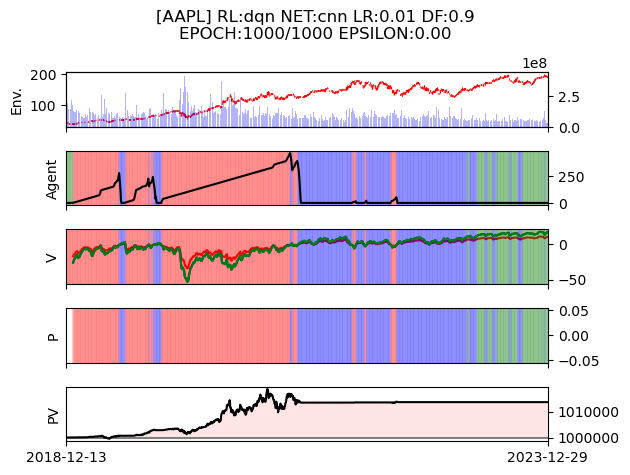

In [37]:
run_trader(stock_name='Apple', stock_code='AAPL', num_epochs=1000)

In [38]:
# # reset replay buffer
# init_replay_buffer_size = int(learner.replay_memory.replay_capacity * learner.replay_memory.replay_init_ratio)
# s = agent.reset()
# step_count = 0

# # create initial replay buffer
# for _ in range(learner.replay_memory.replay_capacity):
#     a = np.random.choice(agent.NUM_ACTIONS)     # uniform random action
#     confidence = np.random.random()
#     s_next, r, done, info = agent.step(a, confidence=confidence)
#     step_count += 1
#     s = s_next
#     if done:
#         env.reset()
#         agent.reset()
#         step_count = 0

In [39]:
# # train agent
# train_env_steps = 20 * 12 * 3
# target_update_period = 20 * 3
# env.reset()
# s = agent.reset()
# step_count = 0
# for step_train in range(train_env_steps):
#     eps = get_eps(step=step_train)
#     is_random_action = np.random.choice(2, p=[1 - eps, eps])
#     if is_random_action:
#         a = np.random.choice(agent.NUM_ACTIONS)     # uniform random action
#     else:
#         a = learner.get_argmax_action(s)
        
#     confidence = np.random.random()
#     s_next, r, done, info = agent.step(a, confidence)
#     step_count += 1
    
#     transition = (s, a, r, s_next, done)
#     learner.replay_memory.append(transition)
    
#     s = s_next
#     if done:
#         env.reset()
#         s = agent.reset()
#         step_count = 0
        
#     # target update period
#     if step_train % target_update_period == 0:
#         learner.update_target_network()
        
#     # train every 5 steps
#     if step_train % 5 == 0:
#         loss = learner.train()